## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Sean\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Sean\Anaconda3

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp_pre_a(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
            x = BatchNormalization()(x)
            
        else:

            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
MODE = ['pre_a', 'post_a']

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for mode in MODE:
    for batchsize in BATCH_SIZE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        if mode == 'pre_a':
            model = build_mlp_pre_a(input_shape=x_train.shape[1:])
        else:
            model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=batchsize, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)
    
        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]
    
        exp_name_tag = "exp-l2-%s-%s" %(mode, str(batchsize))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               3289

50000/50000 [==============================] - 293s 6ms/step - loss: 2.2397 - accuracy: 0.1688 - val_loss: 3.1777 - val_accuracy: 0.2029
Epoch 45/50
50000/50000 [==============================] - 292s 6ms/step - loss: 2.2391 - accuracy: 0.1701 - val_loss: 3.1441 - val_accuracy: 0.1852
Epoch 46/50
50000/50000 [==============================] - 276s 6ms/step - loss: 2.2335 - accuracy: 0.1703 - val_loss: 2.4884 - val_accuracy: 0.1731
Epoch 47/50
50000/50000 [==============================] - 275s 5ms/step - loss: 2.2360 - accuracy: 0.1724 - val_loss: 2.3485 - val_accuracy: 0.1936
Epoch 48/50
50000/50000 [==============================] - 274s 5ms/step - loss: 2.2333 - accuracy: 0.1721 - val_loss: 2.3767 - val_accuracy: 0.1755
Epoch 49/50
50000/50000 [==============================] - 278s 6ms/step - loss: 2.2328 - accuracy: 0.1721 - val_loss: 2.5585 - val_accuracy: 0.1590
Epoch 50/50
50000/50000 [==============================] - 275s 5ms/step - loss: 2.2344 - accuracy: 0.1705 - val_loss:

50000/50000 [==============================] - 38s 765us/step - loss: 0.7265 - accuracy: 0.7439 - val_loss: 1.4054 - val_accuracy: 0.5500
Epoch 39/50
50000/50000 [==============================] - 39s 775us/step - loss: 0.7177 - accuracy: 0.7466 - val_loss: 1.4125 - val_accuracy: 0.5496
Epoch 40/50
50000/50000 [==============================] - 41s 813us/step - loss: 0.7098 - accuracy: 0.7504 - val_loss: 1.4141 - val_accuracy: 0.5509
Epoch 41/50
50000/50000 [==============================] - 40s 808us/step - loss: 0.6970 - accuracy: 0.7542 - val_loss: 1.4010 - val_accuracy: 0.5541
Epoch 42/50
50000/50000 [==============================] - 43s 858us/step - loss: 0.6860 - accuracy: 0.7579 - val_loss: 1.4432 - val_accuracy: 0.5432
Epoch 43/50
50000/50000 [==============================] - 44s 871us/step - loss: 0.6743 - accuracy: 0.7618 - val_loss: 1.4473 - val_accuracy: 0.5495
Epoch 44/50
50000/50000 [==============================] - 44s 883us/step - loss: 0.6732 - accuracy: 0.7620 - va

50000/50000 [==============================] - 19s 371us/step - loss: 0.4722 - accuracy: 0.8333 - val_loss: 1.7161 - val_accuracy: 0.5369
Epoch 33/50
50000/50000 [==============================] - 18s 369us/step - loss: 0.4570 - accuracy: 0.8383 - val_loss: 1.7306 - val_accuracy: 0.5408
Epoch 34/50
50000/50000 [==============================] - 19s 370us/step - loss: 0.4517 - accuracy: 0.8384 - val_loss: 1.7437 - val_accuracy: 0.5354
Epoch 35/50
50000/50000 [==============================] - 18s 367us/step - loss: 0.4282 - accuracy: 0.8480 - val_loss: 1.7714 - val_accuracy: 0.5407
Epoch 36/50
50000/50000 [==============================] - 18s 366us/step - loss: 0.4391 - accuracy: 0.8446 - val_loss: 1.7589 - val_accuracy: 0.5368
Epoch 37/50
50000/50000 [==============================] - 18s 366us/step - loss: 0.4166 - accuracy: 0.8523 - val_loss: 1.8157 - val_accuracy: 0.5351
Epoch 38/50
50000/50000 [==============================] - 20s 403us/step - loss: 0.4114 - accuracy: 0.8530 - va

50000/50000 [==============================] - 6s 127us/step - loss: 0.2239 - accuracy: 0.9286 - val_loss: 2.0837 - val_accuracy: 0.5037
Epoch 27/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.2076 - accuracy: 0.9338 - val_loss: 2.0768 - val_accuracy: 0.5136
Epoch 28/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.1949 - accuracy: 0.9377 - val_loss: 2.1478 - val_accuracy: 0.5071
Epoch 29/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.1925 - accuracy: 0.9389 - val_loss: 2.1682 - val_accuracy: 0.5089
Epoch 30/50
50000/50000 [==============================] - 7s 138us/step - loss: 0.1718 - accuracy: 0.9462 - val_loss: 2.1864 - val_accuracy: 0.5127
Epoch 31/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.1604 - accuracy: 0.9494 - val_loss: 2.2342 - val_accuracy: 0.5110
Epoch 32/50
50000/50000 [==============================] - 6s 130us/step - loss: 0.1523 - accuracy: 0.9517 - val_loss:

50000/50000 [==============================] - 4s 89us/step - loss: 0.3839 - accuracy: 0.8874 - val_loss: 1.7861 - val_accuracy: 0.4991s - loss: 0.3785 - accuracy: 0.89 - ETA: 0s
Epoch 21/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.3466 - accuracy: 0.8988 - val_loss: 1.8211 - val_accuracy: 0.5018
Epoch 22/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.3157 - accuracy: 0.9105 - val_loss: 1.8743 - val_accuracy: 0.4969
Epoch 23/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.2863 - accuracy: 0.9195 - val_loss: 1.9179 - val_accuracy: 0.4989
Epoch 24/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.2574 - accuracy: 0.9298 - val_loss: 1.9603 - val_accuracy: 0.5002
Epoch 25/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.2328 - accuracy: 0.9391 - val_loss: 1.9960 - val_accuracy: 0.4928
Epoch 26/50
50000/50000 [==============================] - 5s 95us/step - loss: 0

50000/50000 [==============================] - 259s 5ms/step - loss: 2.2525 - accuracy: 0.1560 - val_loss: 32.9878 - val_accuracy: 0.1545
Epoch 16/50
50000/50000 [==============================] - 265s 5ms/step - loss: 2.2561 - accuracy: 0.1521 - val_loss: 146.3812 - val_accuracy: 0.1703
Epoch 17/50
50000/50000 [==============================] - 282s 6ms/step - loss: 2.2585 - accuracy: 0.1504 - val_loss: 235.2365 - val_accuracy: 0.1566
Epoch 18/50
50000/50000 [==============================] - 284s 6ms/step - loss: 2.2647 - accuracy: 0.1454 - val_loss: 209.9386 - val_accuracy: 0.1674
Epoch 19/50
50000/50000 [==============================] - 273s 5ms/step - loss: 2.2677 - accuracy: 0.1413 - val_loss: 824.7484 - val_accuracy: 0.1714
Epoch 20/50
50000/50000 [==============================] - 268s 5ms/step - loss: 2.2714 - accuracy: 0.1431 - val_loss: 39611.1159 - val_accuracy: 0.1442
Epoch 21/50
50000/50000 [==============================] - 266s 5ms/step - loss: 2.2650 - accuracy: 0.147

50000/50000 [==============================] - 34s 682us/step - loss: 1.3951 - accuracy: 0.5032 - val_loss: 1.3956 - val_accuracy: 0.5040
Epoch 11/50
50000/50000 [==============================] - 34s 684us/step - loss: 1.3821 - accuracy: 0.5089 - val_loss: 1.4001 - val_accuracy: 0.5004
Epoch 12/50
50000/50000 [==============================] - 35s 698us/step - loss: 1.3658 - accuracy: 0.5142 - val_loss: 1.4247 - val_accuracy: 0.4937
Epoch 13/50
50000/50000 [==============================] - 34s 688us/step - loss: 1.3557 - accuracy: 0.5207 - val_loss: 1.3978 - val_accuracy: 0.5103
Epoch 14/50
50000/50000 [==============================] - 35s 709us/step - loss: 1.3487 - accuracy: 0.5237 - val_loss: 1.4055 - val_accuracy: 0.5031
Epoch 15/50
50000/50000 [==============================] - 35s 709us/step - loss: 1.3258 - accuracy: 0.5299 - val_loss: 1.4424 - val_accuracy: 0.4810
Epoch 16/50
50000/50000 [==============================] - 37s 733us/step - loss: 1.3109 - accuracy: 0.5355 - va

Epoch 5/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.3856 - accuracy: 0.5053 - val_loss: 1.5232 - val_accuracy: 0.4646
Epoch 6/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.3554 - accuracy: 0.5196 - val_loss: 1.5967 - val_accuracy: 0.4295
Epoch 7/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.3258 - accuracy: 0.5290 - val_loss: 1.4599 - val_accuracy: 0.4777
Epoch 8/50
50000/50000 [==============================] - 17s 336us/step - loss: 1.3015 - accuracy: 0.5368 - val_loss: 1.4846 - val_accuracy: 0.4751
Epoch 9/50
50000/50000 [==============================] - 17s 335us/step - loss: 1.2677 - accuracy: 0.5475 - val_loss: 1.4758 - val_accuracy: 0.4838
Epoch 10/50
50000/50000 [==============================] - 17s 336us/step - loss: 1.2417 - accuracy: 0.5575 - val_loss: 1.4787 - val_accuracy: 0.4902
Epoch 11/50
50000/50000 [==============================] - 16s 328us/step - loss: 1.2207 - accuracy: 0.56

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7627 - accuracy: 0.3877 - val_loss: 1.6613 - val_accuracy: 0.4060
Epoch 2/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.4934 - accuracy: 0.4748 - val_loss: 1.6061 - val_accuracy: 0.4415
Epoch 3/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.3972 - accuracy: 0.5071 - val_loss: 1.5402 - val_accuracy: 0.4606
Epoch 4/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.3277 - accuracy: 0.5333 - val_loss: 1.5225 - val_accuracy: 0.4610
Epoch 5/50
50000/50000 [==============================] - 6s 114us/step - loss: 1.2715 - accuracy: 0.5535 - val_loss: 1.5014 - val_accuracy: 0.4708
Epoch 6/50
50000/50000 [==============================] - 6s 115us/step - loss: 1.2178 - accuracy: 0.5742 - val_loss: 1.4703 - val_accuracy: 0.4828
Epoch 7/50
50000/50000 [==============================] - 6s 1

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.8565 - accuracy: 0.3618 - val_loss: 1.7364 - val_accuracy: 0.3912
Epoch 2/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.5368 - accuracy: 0.4616 - val_loss: 1.5688 - val_accuracy: 0.4414
Epoch 3/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.4296 - accuracy: 0.4981 - val_loss: 1.5810 - val_accuracy: 0.4442
Epoch 4/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.3553 - accuracy: 0.5264 - val_loss: 1.4966 - val_accuracy: 0.4680
Epoch 5/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.2924 - accuracy: 0.5476 - val_loss: 1.4894 - val_accuracy: 0.4757
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.2428 - accuracy: 0.5674 - val_loss: 1.5641 - val_accuracy: 0.4488
Epoch 7/50
50000/50000 [==============================] - 4s 75us/st

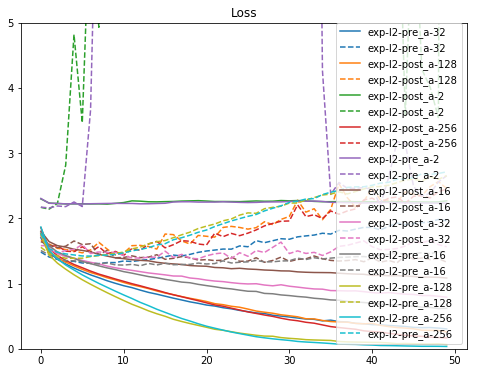

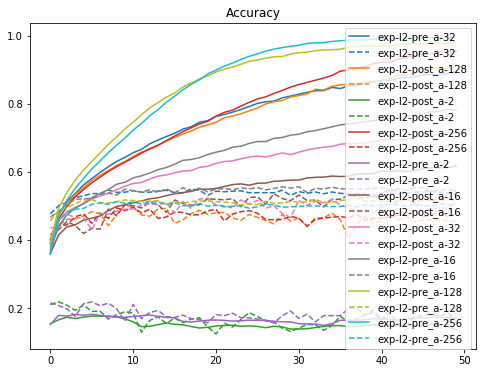

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["C0", "C1", "C2", "C3", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()